# Data Model Evaluation with SHAP Values Lagged Values
* In the presented notebook we will try to get more insights and understand what our model is doing. Check the importance of features, its sign and its effect on our target variable Rreproduction rate.
* This evaluation analysis of shap values will work **including the lagged variable reproduction rate of week n-2**.
* This evaluation analysis of shap values will work **without mobility indexes**.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
import shap
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pickle

## Authenticate to Google Drive 
(Request access to lucasbotellaroca@gmail.com if not conceded)

In [31]:
# A browser window will open. Login using the appropriate account.
gauth = GoogleAuth()
gauth.LocalWebserverAuth() #

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [32]:
drive = GoogleDrive(gauth)

In [33]:
drive

## Auxiliary Functions

In [34]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(reg2_gbr)
    shap_values_Model = explainerModel.shap_values(X_train)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train.iloc[[j]])
    return(p)

In [35]:
def read_csv_file(folder, fileName, nrows):
    
    read_file = drive.ListFile({'q': "title contains '" + fileName + ".csv' and '" + folder + "' in parents"}).GetList()
    
    if len(read_file)>0:
        title = read_file[0]['title']
        id = read_file[0]['id']
        each_file = drive.CreateFile({'id': id})
        each_file.GetContentFile(title)
        df = pd.read_csv(title, skiprows=nrows)
    else:
        
        df=pd.DataFrame()
    
    return df

In [36]:
def get_reproduction_rate_previous_2_weeks(df):
    rate_tendency=[]
    country='AUS'

    for index, row in df.iterrows():
        country_last=row['Code']

        if(country==country_last):

            date_1 = pd.to_datetime(row['Date']) - pd.to_timedelta(14, unit='d')
            s_1 = df[(df['Code']==country) & (pd.to_datetime(df['Date'])== date_1)]['reproduction_rate']
           

            if (s_1.size==0):

                n=row['reproduction_rate']

            else: 
               
                n=s_1.iloc[0]

            rate_tendency.append(n)

        else:
            country=country_last
            rate_tendency.append(row['reproduction_rate'])

    return rate_tendency

## Read File and Prepare Data

* Same transofrmation as in the data model notebook is performed. 

In [80]:
#df=pd.read_csv('../df_covid_processed_final_reproduction_rate.csv')
df=read_csv_file('1kNVBQTd_m6OihGl5zXfkcbin9BtKzFEw','df_covid_processed_final_reproduction_rate',0)

df=df[['Code', 'Date','debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', 'youth_unemployment','infections_value',
      'accumulated','reproduction_rate']]

#We still need to filter on infectious data since proxy variable is the same as accumualted and if not we would be losing importnace of that variable
df = df[df['infections_value'].notna()]
del df['infections_value']
#Since our new infectious indicator is reproduction rate week n-2 we remove it
df = df[df['accumulated'].notna()]
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['Date'] = pd.to_datetime(df['Date'])
    
# Grouping data over 2 week intervals in order to increment the variability and response of our features on the target variable.
df = df.groupby(['Code', pd.Grouper(key='Date', freq='2W-SUN')]).mean().reset_index()

df['reproduction_rate_week_n-2']=get_reproduction_rate_previous_2_weeks(df)
df=df[[c for c in df if c not in ['reproduction_rate']] 
       + ['reproduction_rate']]

df

,Code,Date,debt_relief,income_support,testing_policy,international_travel_controls,restrictions_internal_movements,close_public_transport,public_information_campaigns,facial_coverings,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,accumulated,reproduction_rate_week_n-2,reproduction_rate
0,AUS,2020-03-22,0.000000,0.0,1.000000,3.000000,0.0,0.0,2.0,0.0,...,0.0,21.346512,0.142010,8263000.0,85.904,0.000000,11.84,0.002502,2.170000,2.170000
1,AUS,2020-04-05,0.142857,1.0,1.000000,3.428571,1.0,0.0,2.0,0.0,...,0.0,20.939890,0.053343,8263000.0,85.904,0.000000,11.84,0.003440,2.170000,2.305000
2,AUS,2020-04-19,2.000000,1.0,1.000000,4.000000,2.0,0.0,2.0,0.0,...,0.0,19.987036,0.095946,8263000.0,85.904,0.000000,11.84,0.005606,2.305000,1.111429
3,AUS,2020-05-03,2.000000,1.0,1.000000,4.000000,2.0,0.0,2.0,0.0,...,1.0,19.008360,0.046547,8263000.0,85.904,0.000000,11.84,0.007019,1.111429,0.432857
4,AUS,2020-05-17,2.000000,1.0,2.428571,4.000000,2.0,0.0,2.0,0.0,...,0.5,16.998547,0.082838,8263000.0,85.904,0.000000,11.84,0.008205,0.432857,0.589286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,USA,2021-01-10,1.000000,2.0,3.000000,3.000000,2.0,1.0,2.0,4.0,...,0.5,2.296861,0.059487,75608000.0,82.058,0.451667,8.30,0.184976,1.095000,0.977857
1233,USA,2021-01-24,1.000000,2.0,3.000000,3.000000,2.0,1.0,2.0,4.0,...,0.5,1.849448,0.066435,75608000.0,82.058,1.939500,8.30,0.205035,0.977857,1.070000
1234,USA,2021-02-07,1.000000,2.0,3.000000,3.000000,2.0,1.0,2.0,4.0,...,0.5,2.291674,0.043928,75608000.0,82.058,5.282857,8.30,0.220400,1.070000,0.870714
1235,USA,2021-02-21,1.000000,2.0,3.000000,3.000000,2.0,1.0,2.0,4.0,...,0.0,-0.303134,0.044132,75608000.0,82.058,10.600000,8.30,0.230417,0.870714,0.802857


In [81]:
df_appch2=df.copy()
df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_closures_measures']=0.3*df_appch2['stay_home_requirements']\
                                + 0.3*df_appch2['restriction_gatherings']\
                                + 0.2*df_appch2['restrictions_internal_movements']\
                                + 0.1*df_appch2['international_travel_controls']\
                                + 0.1*df_appch2['close_public_transport']\
                                + 0.2*df_appch2['cancel_public_events']\
                                + 0.4*df_appch2['workplace_closures']\
                                + 0.4*df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date',
                     'awareness_measures', 'health_measures',
                     'mobility_closures_measures', 'economic_measures',
                     'holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                     'total_vaccinations_per_100', 'youth_unemployment',
                     'accumulated', 'reproduction_rate_week_n-2','reproduction_rate']]

In [82]:
df_time=df_appch2.sort_values('Date')
X=df_time[df_time.columns[2:-1]]
y=df_time[df_time.columns[-1]]
X_train, X_test = X.iloc[0:1148], X.iloc[1148:1237]   
y_train, y_test = y.iloc[0:1148], y.iloc[1148:1237]

In [83]:
X_train

,awareness_measures,health_measures,mobility_closures_measures,economic_measures,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,accumulated,reproduction_rate_week_n-2
686,0.4,2.500000,2.842857,0.000000,0.0,5.561562,0.181441,17242000.0,81.503,0.000000,9.820000,0.000872,4.285000
631,0.4,1.571429,3.442857,0.000000,0.0,6.668070,0.024724,52372000.0,70.144,0.000000,29.219999,0.000000,3.500000
0,0.4,1.500000,0.300000,0.000000,0.0,21.346512,0.142010,8263000.0,85.904,0.000000,11.840000,0.002502,2.170000
361,0.4,1.000000,0.528571,0.000000,0.0,11.700601,0.076047,75315000.0,80.080,0.000000,32.610001,0.000000,3.097857
295,0.4,0.571429,0.771429,0.428571,0.0,5.280772,0.039222,10781000.0,87.757,0.000000,10.050000,0.000000,2.080000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,3.6,1.500000,4.100000,2.000000,0.0,10.603313,0.053999,75315000.0,80.080,6.201000,32.610001,0.214197,0.892857
933,2.0,2.000000,4.357143,1.000000,1.0,-3.129332,0.072924,5960000.0,81.871,6.635714,9.880000,0.014508,0.880714
131,3.6,0.500000,5.128571,0.000000,2.0,24.892013,0.038313,6578000.0,86.309,2.435714,27.469999,0.038372,1.021429
442,1.2,1.500000,3.800000,1.500000,0.0,-12.007017,0.025452,2789000.0,85.325,5.572143,17.090000,0.043507,1.087857


## Import Models and Evaluate Shap Values
We will perform evaluation and analysis of the impact of variables on the training set predictions (year 2020).

In [86]:
pickle_file='../models/model_lgbm_reg_lags'
reg2_gbr = pickle.load(open(pickle_file,'rb'))

### Tree explainer Bar Plot
We will plot our feature importance bar plot, this will represent the importance of each feature in terms of predictions of our target variable reproduction_rate

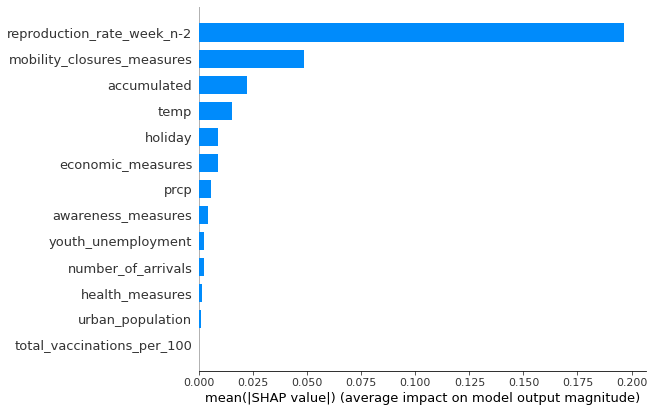

In [87]:
shap_values = shap.TreeExplainer(reg2_gbr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [88]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
12,reproduction_rate_week_n-2,0.196735
2,mobility_closures_measures,0.048408
11,accumulated,0.022286
5,temp,0.015162
4,holiday,0.008506
3,economic_measures,0.008496
6,prcp,0.005265
0,awareness_measures,0.004235
10,youth_unemployment,0.002130
7,number_of_arrivals,0.002078


* As seen variables that seem to have a higher impact on our target variable reproduction rate are:
    * **reproduction_rate_week_n-2** which represents the reprodcution rate value of 2 weeks previous to the predicted value.
    * **mobility_closures_measures** which represent the restrictions in mobility and closings applied.
    * **accumulated** which represents the amount of people that have already contracted the virus
    * **mobility_index** which represents the mobility increase or decrease in reatil and recreation, transit stations, groceries, pharmacy and workplaces
    * **temp** which represents the mean temperature presented in 2 week period

* Other variables that have smaller coefficients are **economic_measures, infectious value, prcp, holiday, youth unemployment, awareness_measures, health_measures, number_of_arrivals, urban_population and total_vaccinations_per_100** don´t seem to have a big impact on the target variable based on the mean shap values shown.

## Generalization of shap values
* Code extracted from (https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

invalid value encountered in true_divide
invalid value encountered in true_divide


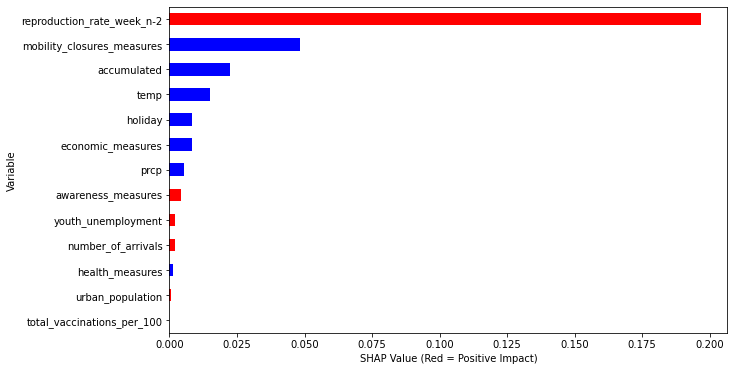

In [89]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

* In blue we can see variables that have negative sign or negative impact on the increase of reproduction rate and on red we can see variables that have positive sign or positive impact on our target variable.

* There some unexpected values such as health_measures and awareness measures that seem to be positive for the virus, we will analyze those separetly.

### Tree explainer Plot

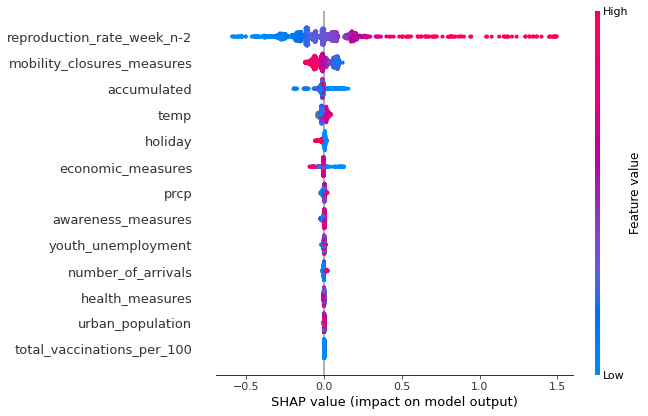

In [90]:
explainer = shap.TreeExplainer(reg2_gbr)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

We will perform a resume of the variables and its impact on our traget vairable **reproduction rate**

> * **reproduction_rate_week_n-2** which represents the reprodcution rate value of 2 weeks previous to the predicted value.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    
> **mobility_closure_measures** which are the restrictions in closings applied by governments.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    
> **accumulated** which represents the amount of current people infecting.
    > * very difuse sign in values.
    
> **temp** which represents the average temperature in selected 2 week period.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    
> **holiday** which represents the number of holidays in selected 2 week period.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    
> **economic_measures** which represents the average temperature in selected 2 week period.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    
* The rest of the coefficients seem to have little influence in the target variable and the coeficients and importance of those variable may be absorved by some other variables previously mentioned. 

* health_measures and mobility measures seem to be getting confusing shap values,will analyze those in detaill taking usage of single variables dependence plots analysis.

* This model mainly makes its predictions based on our lag variable, mobility_closure_measuress, accumulated, temperature and economic measures.

Some other variables may have such coefficients due to multicollinearity with other variables, based on the correlation matrix shown below. In order to detect this multicollinearity issues will analyze each of this features separately and its possible relation with some other more dominant features.

## Single Variables Dependence Plots Analysis

##### awareness_measures

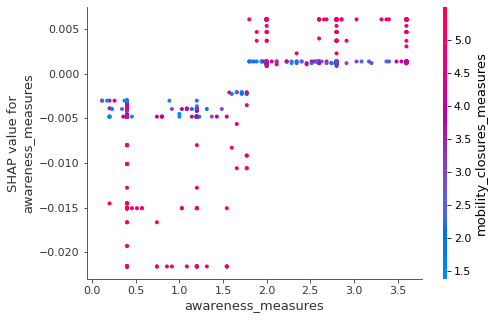

In [91]:
shap.dependence_plot("awareness_measures", shap_values, X_train)

* Awareness measures don't seem to have any relation with mobility closure measures based on shap values therefore its meaning ans sign cannot be determined.

##### health_measures

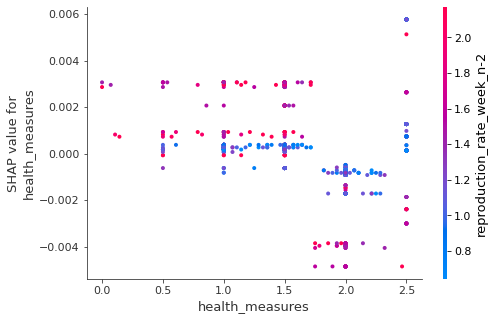

In [92]:
shap.dependence_plot("health_measures", shap_values, X_train)

* Awareness measures don't seem to have any relation with mobility closure measures based on shap values therefore its meaning ans sign cannot be determined.

<AxesSubplot:>

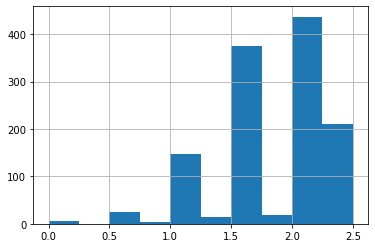

In [93]:
df_appch2.health_measures.hist()

* This variable doesn't seem to have relation with any other feature in the dataset. This variable reflects government  measures on testing and tracing cases. The referenced variable does not appear to have a big impact on the target variable, which is something confusing, however, no possible explanation has been found.
* However our target variable in the end is a very precise estimation taken from a reliable source as detailed in memory.pdf. And such variable is calculated in relation with number of positive cases among a lot other variablesand complex calculations, maybe an increasing number of testing and contact tracing is related in this case with the sign of the referenced variable.

##### total_vaccinations_per_100

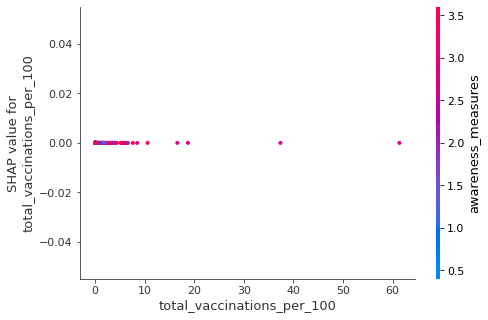

In [94]:
shap.dependence_plot("total_vaccinations_per_100", shap_values, X_train)

* This variable is of course predicticably the variable that should predict the most together with accumulated and infections, in fact it should have the same effect as accumulated, however since there is very few data collected for train of the model since vaccinations started in 2021 approximately, the model is not including it as an important feature, however in future analysis with more amount of data this variable will predictably have the same weight as accumulated.

## Quick look over some predictions

In [95]:
#Real value
y_train.iloc[140]

0.5092857142857143

In [96]:
#Estimation
shap.initjs()
shap_plot(140)

In [97]:
#Real value
y_train.iloc[800]

0.9928571428571428

In [98]:
#Estimation
shap.initjs()
shap_plot(800)

In [99]:
#Real value
y_train.iloc[650]

1.3185714285714285

In [100]:
#Estimation
shap.initjs()
shap_plot(650)

* Mobilty_closures_measures of 2 is considered to be low, values range from (0 to 6)

In [101]:
#Real value
y_train.iloc[71]

1.5764285714285715

In [102]:
#Estimation
shap.initjs()
shap_plot(71)

In [103]:
#Real value
y_train.iloc[170]

1.0307142857142857

In [104]:
#Estimation
shap.initjs()
shap_plot(170)

## Conclusion

* Overall the presented model as seen in [03_data_model_evaluation_lags.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation_lags.ipynb) offers good and precise predictions according to metrics mae and mape studied. Therefore it could be used to create predictions, however it is a model that highly relies on the values of reproduction rate prior two weeks, therefore it might not capture big changes in restrictions or tendencies, it behaves well according to the behaviour appeared in the dataset.

* However, it is able to detect changes in trend as seen above, were reproduction_rate_week_n-2 does not have all the explanation of the prediction but it does have most of it.

* From an explanatory point of view as seen in this notebook most features have zero to very small effect on the target variable, and the signs of each feature seem to be confusing as well for some cases. However just as with the non lagged version, this is due to multicollinearity, variable mobility_closures_measurees captures all the effect of the rest of restrictions, since restrictions tend to be applied at the same time with the same severity.